
Offspring 1: [34, 77, 16, 22, 64, 49, 54, 83, 95, 78, 39, 71, 36, 1, 28, 70, 10, 36, 20, 76, 56, 41, 39, 58, 17, 50, 84, 100, 41, 55, 14, 43, 31, 35, 48, 99, 0, 12, 75, 11, 93, 24, 0, 72, 46, 65, 34, 58, 9, 38, 30, 87, 26, 83, 85, 96, 69, 88, 82, 13, 67, 45, 75, 3, 10, 68, 27, 86, 6, 47, 92, 30, 21, 71, 19, 44, 42, 80, 59, 56, 94, 81, 59, 61, 26, 73, 16, 86, 73, 69, 42, 89, 78, 45, 12, 47, 37, 53, 13, 37, 74]
Offspring 2: [19, 5, 7, 6, 14, 89, 18, 35, 23, 97, 87, 29, 80, 2, 82, 1, 40, 68, 4, 52, 96, 5, 33, 63, 49, 32, 84, 98, 11, 94, 51, 8, 20, 66, 24, 3, 63, 90, 85, 40, 57, 98, 54, 4, 15, 90, 61, 9, 33, 60, 99, 88, 53, 7, 27, 79, 18, 44, 25, 48, 21, 22, 76, 25, 72, 95, 52, 100, 91, 2, 66, 79, 55, 28, 38, 46, 32, 29, 93, 70, 43, 62, 65, 23, 17, 67, 62, 51, 92, 97, 57, 81, 15, 31, 60, 50, 91, 8, 64, 77, 74]

Best route overall: [84, 97, 96, 100, 71, 67, 53, 51, 21, 43, 45, 71, 85, 76, 52, 61, 17, 88, 87, 27, 100, 51, 88, 30, 78, 29, 54, 40, 39, 42, 2, 63, 18, 9, 49, 7, 4, 41, 1, 57, 67

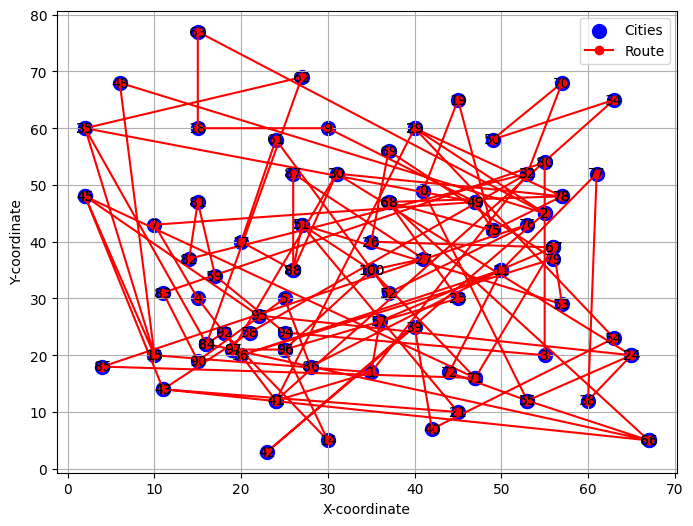

Total CPU time: 137.25 seconds


In [1]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Function to calculate the distance between two cities (Euclidean distance)
def distance(city1, city2):
    return ((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2) ** 0.5

# Function to calculate the total distance of a route
def total_distance(route, cities):
    total = 0
    for i in range(len(route)):
        total += distance(cities[route[i]], cities[route[(i + 1) % len(route)]])
    return total

# Function to generate random cities
# def read_cities_from_file(file_path):
#     cities = []
#     with open(file_path, 'r') as file:
#         for line in file:
#             city_data = line.strip().split()
#             if len(city_data) == 3: #Ensure it's a valid city line
#                 x, y = float(city_data[1]), float(city_data[2])
#                 cities.append((x,y))
#     return cities


def read_cities_from_file(file_path):
    cities = []
    read_cities = False  # Flag to indicate if we have started reading city coordinates
    
    with open(file_path, 'r') as file:
        for line in file:
            if "NODE_COORD_SECTION" in line:
                read_cities = True
                continue
            
            if read_cities:
                city_data = line.strip().split()
                if len(city_data) == 3: # Ensure it's a valid city line
                    x, y = float(city_data[1]), float(city_data[2])
                    cities.append((x, y))
    
    return cities

# Function for IPMX crossover
def ipmx(parent1, parent2):
    n = len(parent1)
    
    # Step 1: Randomly select two cut points, cp1 and cp2, on parent chromosomes, parent1 and parent2.
    cp1, cp2 = sorted(random.sample(range(n), 2))
    
    # Step 2: Produce primitive-offspring1 and primitive-offspring2 by swapping the substrings between cp1 and cp2.
    primitive_offspring1 = parent1[cp1:cp2]
    primitive_offspring2 = parent2[cp1:cp2]
    
    
     # Print the parents and primitive offsprings
    print("Parent 1:", parent1)
    print("Parent 2:", parent2)
    print("Primitive Offspring 1:", primitive_offspring1)
    print("Primitive Offspring 2:", primitive_offspring2)


    # Step 3: Define an exchange list with respect to the chosen substrings.
    exchange_list = [-1] * n  # Initialize exchange_list with -1
    for i in range(cp1, cp2):
        exchange_list[parent2[i]] = parent1[i]

    # Step 4: Generate a directed graph of the exchange list.
    directed_graph = {i: [] for i in range(n)}
    for i in range(cp1, cp2):
        if i != cp1 and exchange_list[parent1[i]] != parent1[i]:
            directed_graph[parent1[i]].append(exchange_list[parent1[i]])
            
    
    # Step 5: Find all distinct paths between nodes in the graph.
    def find_paths(node, path=[]):
        path = path + [node]
        if node == primitive_offspring2[0]:
            return [path]
        paths = []
        for neighbor in directed_graph[node]:
            if neighbor not in path:
                new_paths = find_paths(neighbor, path)
                for new_path in new_paths:
                    paths.append(new_path)
        return paths
    
    # Step 6: For each path that contains more than two nodes, add an edge between two endpoints and then remove all mid nodes.
    def refine_paths(paths):
        refined_paths = []
        for path in paths:
            if len(path) > 2:
                start, end = path[0], path[-1]
                refined_paths.append((start, end))
        return refined_paths
    
    paths = find_paths(primitive_offspring1[0])
    refined_paths = refine_paths(paths)
    
    # Step 7: Update the exchange_list based on the refined paths
    for start, end in refined_paths:
        exchange_list[start] = end
    
    # Step 8: Apply the updated exchange_list to primitive_offspring1 to produce offspring1
    offspring1 = [exchange_list[elem] if exchange_list[elem] != -1 else elem for elem in primitive_offspring1]
    
    # Step 9: Generate F, a list of the same length as the parent chromosomes, initialized to zero
    F = [0] * n
    
    # Step 10: Produce offspring2 by performing the following operations:
    # (a) F[offspring1[i]] = parent1[i]
    # (b) offspring2[i] = F[parent2[i]]
    for i, elem in enumerate(offspring1):
        F[elem] = parent1[cp1 + i]
    
    offspring2 = [F[elem] for elem in parent2]
    
    return offspring1, offspring2

# Genetic Algorithm function using DEAP with IPMX crossover
def genetic_algorithm(cities, population_size, generations, crossover_prob, mutation_prob):
    num_cities = len(cities)
    
    population = toolbox.population(n=population_size)
    best_route = None
    best_distance = float('inf')
    toolbox.register("mate_ipmx", ipmx)
#    just added below 
    fitness_values = [toolbox.evaluate(ind) for ind in population]
        
    for ind, fit in zip(population, fitness_values):
            ind.fitness.values = fit
#             just added above
    
    for gen in range(generations):
        # Instead of using toolbox.map for evaluation, use the evaluate function directly
        fits = [toolbox.evaluate(ind) for ind in population]
        for fit, ind in zip(fits, population):
            ind.fitness.values = fit
        
        # Create offspring using cxOrdered, cxTwoPoint, and IPMX operators
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob)
        population = offspring
        
        # Update the best route and distance
        best_ind = tools.selBest(population, k=1)[0]
        current_best_distance = best_ind.fitness.values[0]
        if current_best_distance < best_distance:
            best_distance = current_best_distance
            best_route = best_ind
    
    return best_route, best_distance

# Function to plot the route
def plot_route(route, cities):
    xs, ys = zip(*[(cities[i][0], cities[i][1]) for i in route])
    xs, ys = list(xs), list(ys)  # Convert to lists
    plt.figure(figsize=(8, 6))
    plt.scatter(xs, ys, color='b', s=100, label='Cities')
    for i, (x, y) in enumerate(zip(xs, ys)):
        plt.text(x, y, str(route[i]), fontsize=10, ha='center', va='center')
    plt.plot(xs + [xs[0]], ys + [ys[0]], linestyle='-', marker='o', color='r', label='Route')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# # Example usage
if __name__ == "__main__":
    start_time = time.time()
    #load cities from the dataset
    file_path = "eil101.tsp"
    cities = read_cities_from_file(file_path)
    
    num_cities = 101
    population_size = 500
    generations = 50
    crossover_prob = 1.0  # Crossover rate of 100% (always perform crossover)
    mutation_prob = 0.0   # Mutation rate of 0% (never perform mutation)
    x_range = (0, 100)
    y_range = (0, 100)
    
    # DEAP setup
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(num_cities), num_cities)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate_ordered", tools.cxOrdered)
    toolbox.register("mate_two_point", tools.cxTwoPoint)
    toolbox.register("mate_ipmx", ipmx)  # Add the IPMX operator to the toolbox
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=mutation_prob)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", lambda ind: (total_distance(ind, cities),))
    
    toolbox.cxpb = crossover_prob
    toolbox.register("mate", tools.cxOrdered)
    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=mutation_prob)

    
# Lists to store the results of each run  
best_routes = []
best_distances = []


# Perform 30 runs of the genetic algorithm
for run in range(30):
    cities = read_cities_from_file(file_path)
    population = toolbox.population(n=population_size)

    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)

    # Initialize best route and distance for the current run
    best_route = None
    best_distance = float('inf')

    for gen in range(generations):
        # Create offspring using cxOrdered, cxTwoPoint, and IPMX operators
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob)
        population = offspring

        for ind in population:
            ind.fitness.values = toolbox.evaluate(ind)

        # Update the best route and distance for the current generation
        best_ind = tools.selBest(population, k=1)[0]
        current_best_distance = best_ind.fitness.values[0]
        if current_best_distance < best_distance:
            best_distance = current_best_distance
            best_route = best_ind[:]

    # Store the best route and distance for each run
    best_routes.append(best_route)
    best_distances.append(best_distance)

    # Print the result of the current run
#     print(f"Run {run + 1} - Best route: {best_route}, Best distance: {best_distance}")

# Find the best route and distance among all runs
best_index = np.argmin(best_distances)
best_route = best_routes[best_index]
best_distance = best_distances[best_index]

 # Print the parents and primitive offsprings
    
print()
print("Offspring 1:", offspring[0])
print("Offspring 2:", offspring[1])

print(f"\nBest route overall: {best_route}")
print(f"Best distance overall: {best_distance}")

# Plot the best route
plot_route(best_route, cities)

end_time = time.time()

# Calculate the CPU time in seconds
cpu_time = end_time - start_time

# Print the CPU time
print(f"Total CPU time: {cpu_time:.2f} seconds")